<a href="https://colab.research.google.com/github/ibrahim-Alasalimy/Arabic-Character-OCR/blob/main/OCR_Letters_Model_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Arabic Handwriting OCR Model - By ***INNOV8***

# Preparing The Data

In [ ]:
#@title Files and Imports
#Files and Imports
#Recommend Using Google Colab
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import cv2 as cv
from IPython.display import clear_output

!gdown "1AEeOPpmK0DM90nS-UEhQTHHXnu4abKNE"
!unzip "/content/arabic_alphabet 2.zip" -d "/content"

clear_output()

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#@title Data Preparation
# List to store images and labels
images = []
labels = []

def Label_ToArabic(n, letter_folder):


    arabic_alphabet = {
        "lam": "ل",
        "5en": "غ",
        "ha2": "ه",
        "kha": "ج",
        "ba": "ب",
        "tta": "ط",
        "kaf": "ك",
        "non": "ن",
        "sen": "س",
        "mem": "م",
        "5a": "خ",
        "shen": "ش",
        "alf": "أ",
        "vha": "ذ",
        "ta": "ت",
        "vad": "ض",
        "fa": "ث",
        "fa2": "ف",
        "thad": "ظ",
        "ya2": "ي",
        "wow": "و",
        "7a": "ح",
        "3en": "ع",
        "sad": "ص",
        "da": "د",
        "za": "ز",
        "ra": "ر",
        "8af": "ق"
    }

    if letter_folder in arabic_alphabet:
        return arabic_alphabet[letter_folder]
    else:
        return f"Invalid letter_folder: {letter_folder}"




# Iterate through the extracted folder
for index, letter_folder in enumerate(os.listdir("/content/arabic_alphabet")):
    # Skip the iteration if letter_folder is "DS_store"
    if letter_folder == ".DS_Store":

        continue

    print(f"Label: {letter_folder}, Image Path: {Label_ToArabic(index, letter_folder)}")
    letter_folder_path = os.path.join("/content/arabic_alphabet", letter_folder)

    # Check if the letter folder is a directory
    if os.path.isdir(letter_folder_path):
        # Iterate through each image in the letter folder
        for image_file in os.listdir(letter_folder_path):
            image_path = os.path.join(letter_folder_path, image_file)

            # Read and preprocess the image (you might need to adjust preprocessing based on your data)
            if image_path.endswith('.png'):
              # Append the image to the list
              images.append(image_path)
              # Extract the label directly from the index
              label = Label_ToArabic(index, letter_folder)
              labels.append(label)

# Convert the lists to NumPy arrays
labels = np.array(labels)


print(len(images))
labels = np.array(labels)
print(len(labels))

print(labels[0])
print('----------')
print(images[0])

clear_output()

In [ ]:
#@title Splitting The Dataset
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_img_paths, X_test, train_labels, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Further split the testing set into validation and testing sets
test_img_paths, validation_img_paths, test_labels, validation_labels = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Check the sizes of the sets
print("Training set size:", len(train_img_paths))
print("Validation set size:", len(validation_img_paths))
print("Testing set size:", len(test_img_paths))

Training set size: 55574
Validation set size: 6947
Testing set size: 6947


In [ ]:
#@title Checking The size of Training Vocab
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))
print(characters)

# Check some label samples.
train_labels_cleaned[:10]
validation_labels_cleaned = validation_labels
test_labels_cleaned = test_labels

Maximum length:  1
Vocab size:  28
{'ب', 'ض', 'د', 'و', 'ذ', 'م', 'ز', 'ت', 'ط', 'ك', 'ق', 'ف', 'أ', 'ص', 'غ', 'ه', 'ع', 'ل', 'ح', 'خ', 'ر', 'س', 'ج', 'ظ', 'ن', 'ث', 'ي', 'ش'}


In [ ]:
#@title Image Preprocessing

# Define AUTOTUNE for automatic optimization of parallelism during data preprocessing
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers using StringLookup
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters using StringLookup
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

#Utility Funciton for Padding and Resizing
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image



#Image and Label Preprocessing
batch_size = 64
padding_token = 99
image_width = 64
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 0)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    print(label)
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label

label=vectorize_label(train_labels_cleaned[0])
indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
label = tf.strings.reduce_join(num_to_char(indices))
label = label.numpy().decode("utf-8")

def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

clear_output()

In [ ]:
#@title Preparing the Datasets

#Preparting the Datasets
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)
clear_output()

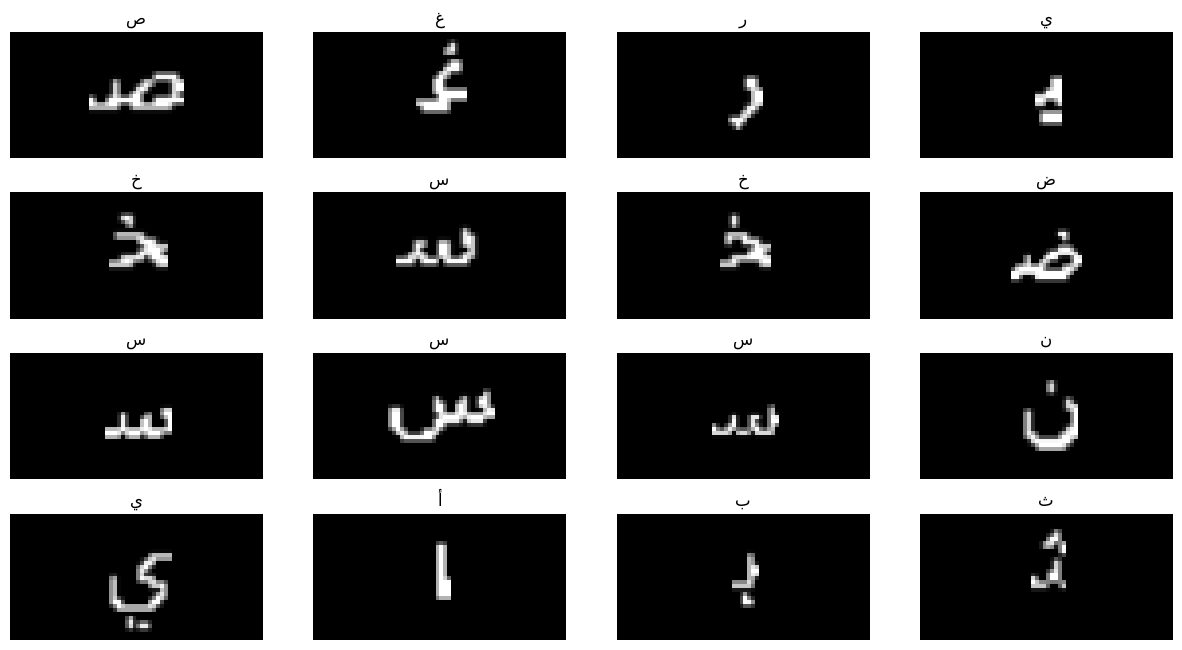

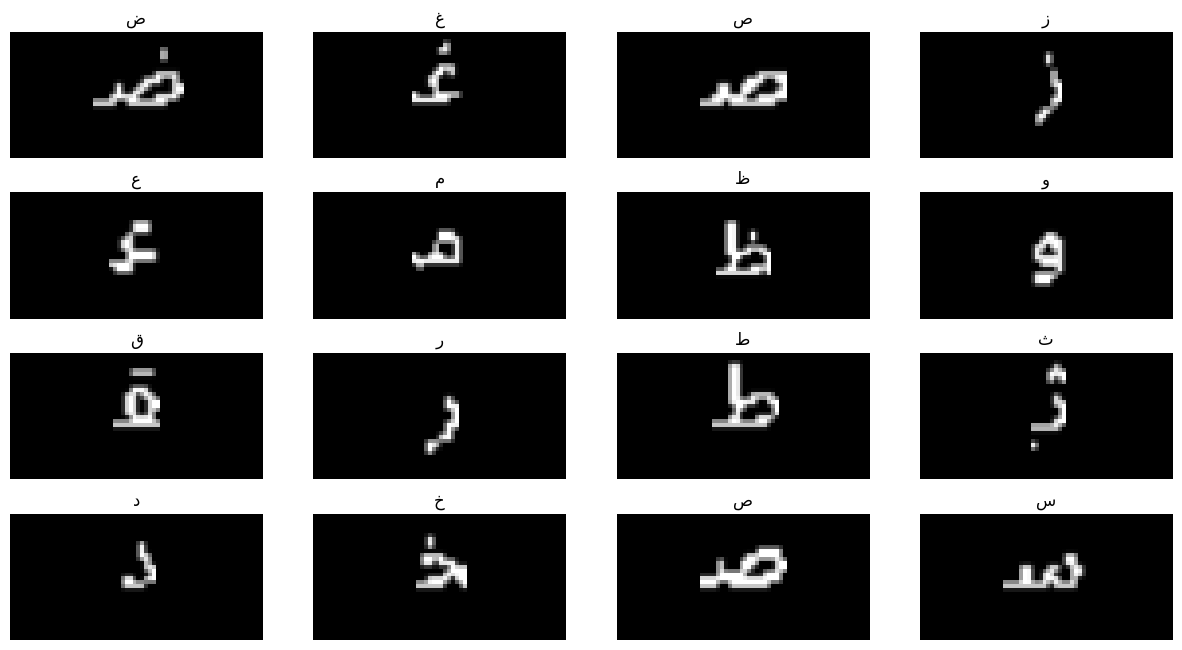

In [ ]:
#@title Inspecting the Training Data

#Inspecting the Training Data
for data in train_ds.take(2):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label[::-1])
        ax[i // 4, i % 4].axis("off")


plt.show()

# Preparing The Model

In [ ]:
#@title Preparing the Model
#Preparing the Model
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred
def get_opt():
  # Optimizer.
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9)
    opt = keras.optimizers.Adam(learning_rate=lr_schedule)
    return opt

def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)
    x= keras.layers.BatchNormalization()(x)
    new_shape = ((image_width // 2), (image_height // 2) * 32)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(16, activation="relu", name="dense2")(x)
    x= keras.layers.BatchNormalization()(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.35))(x)
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense3"
    )(x)
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Compile the model and return.
    model.compile(optimizer=get_opt())
    return model

#Preparing the Validation Samples
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

# Get the model.
model = build_model()
model.summary()


# Function to calculate mean edit distance between predicted and ground truth sequences.
# Utilizes CTC decoding and sparse tensors for predictions and labels.

def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.sparse.from_dense(labels)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]

    predictions_decoded = keras.backend.ctc_decode(

        predictions, input_length=input_len, greedy=False, beam_width=100,
    )[0][0][:, :max_len]
    sparse_predictions =tf.sparse.from_dense(predictions_decoded)

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 64, 32, 1)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 32, 32)           320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 32, 16, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 batch_normalization (Batch  (None, 32, 16, 32)           128       ['pool1[0][0]']               
 Normalization)                                                              

In [ ]:
#@title Model Loading and Training
#Preparing for Training
model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense3").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

import gdown
!gdown "16TbLUXX6pwDauZffw7ODyBQYBCQ7_9aG"
model.load_weights('/content/ocr_32f.keras')
model.evaluate(validation_ds)

# Train the model.
epochs = 1
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
    shuffle=True
)

clear_output()

# Checking The Results

د ق ض ر ب ط خ ق أ ت خ ض ه ص ر ق ظ ث و ز س ف خ ق ك و ز ذ غ ع ص ع ل ظ ب و خ ن خ ن ك ر ل س ط ح ث ذ 

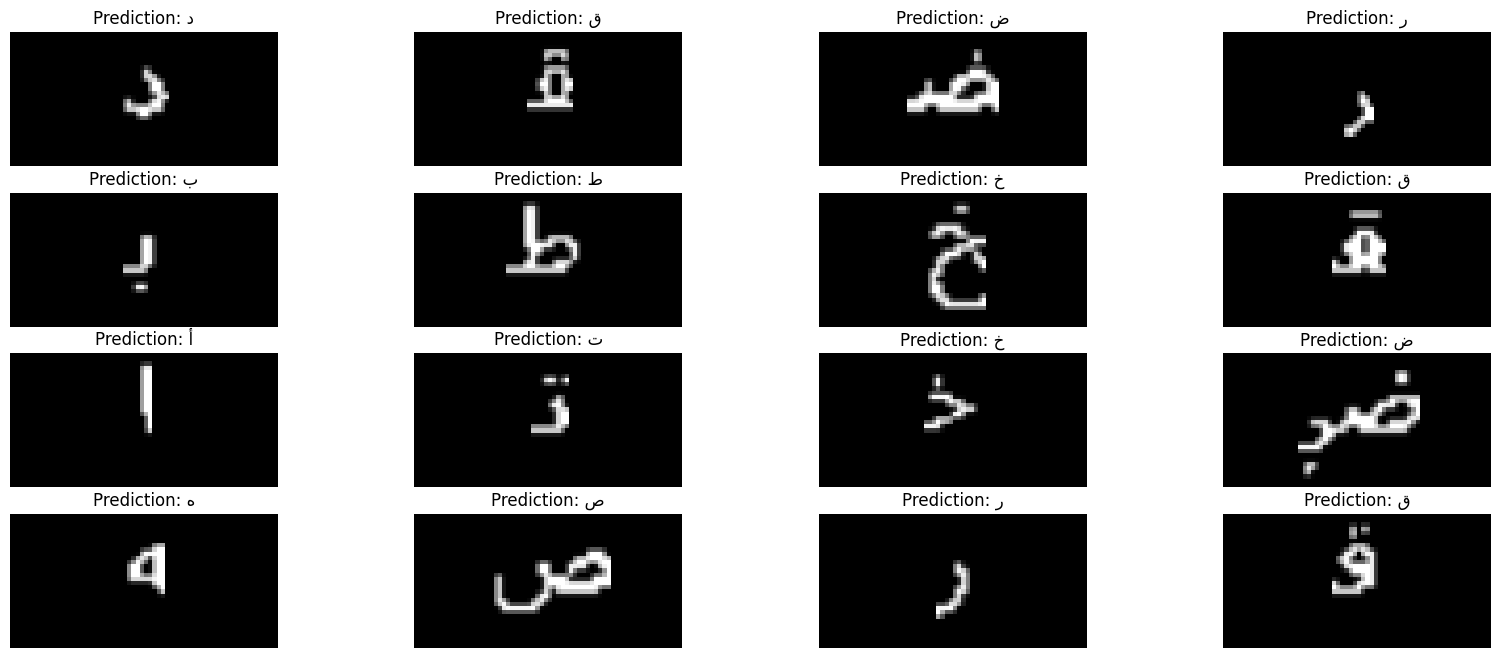

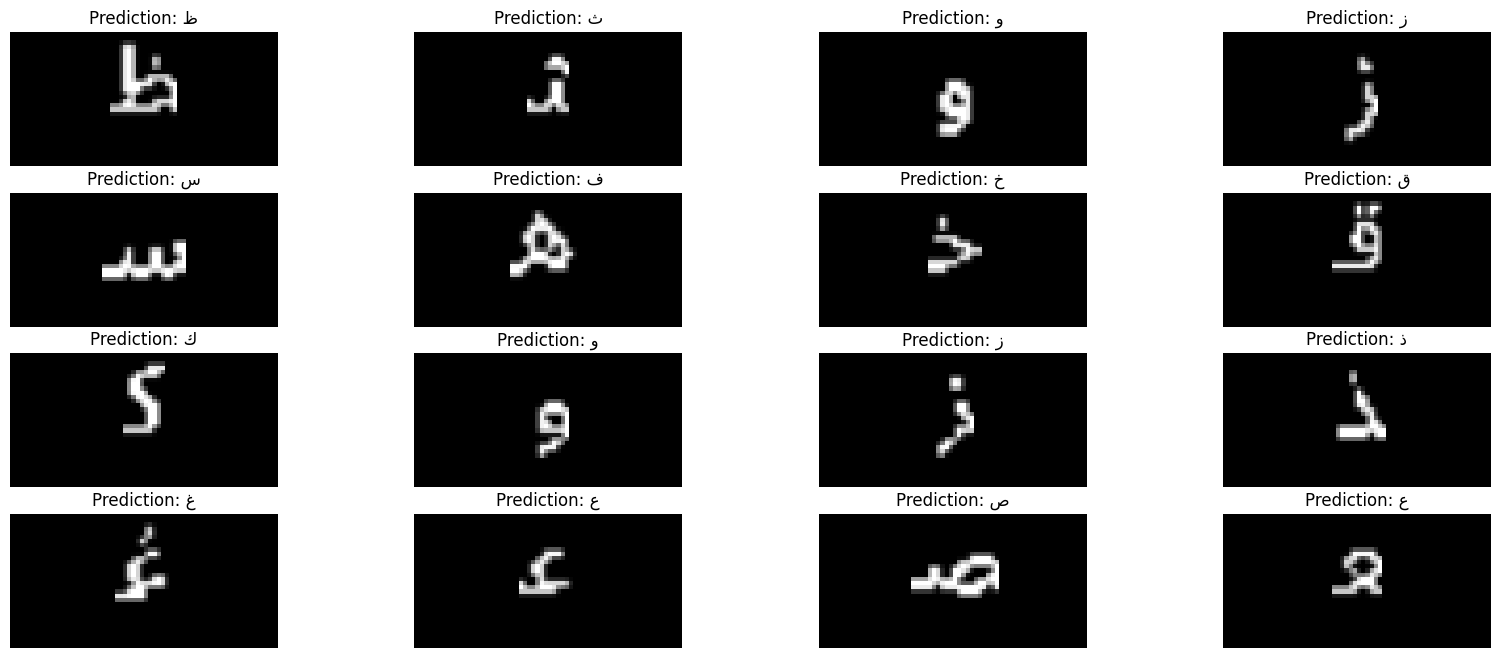

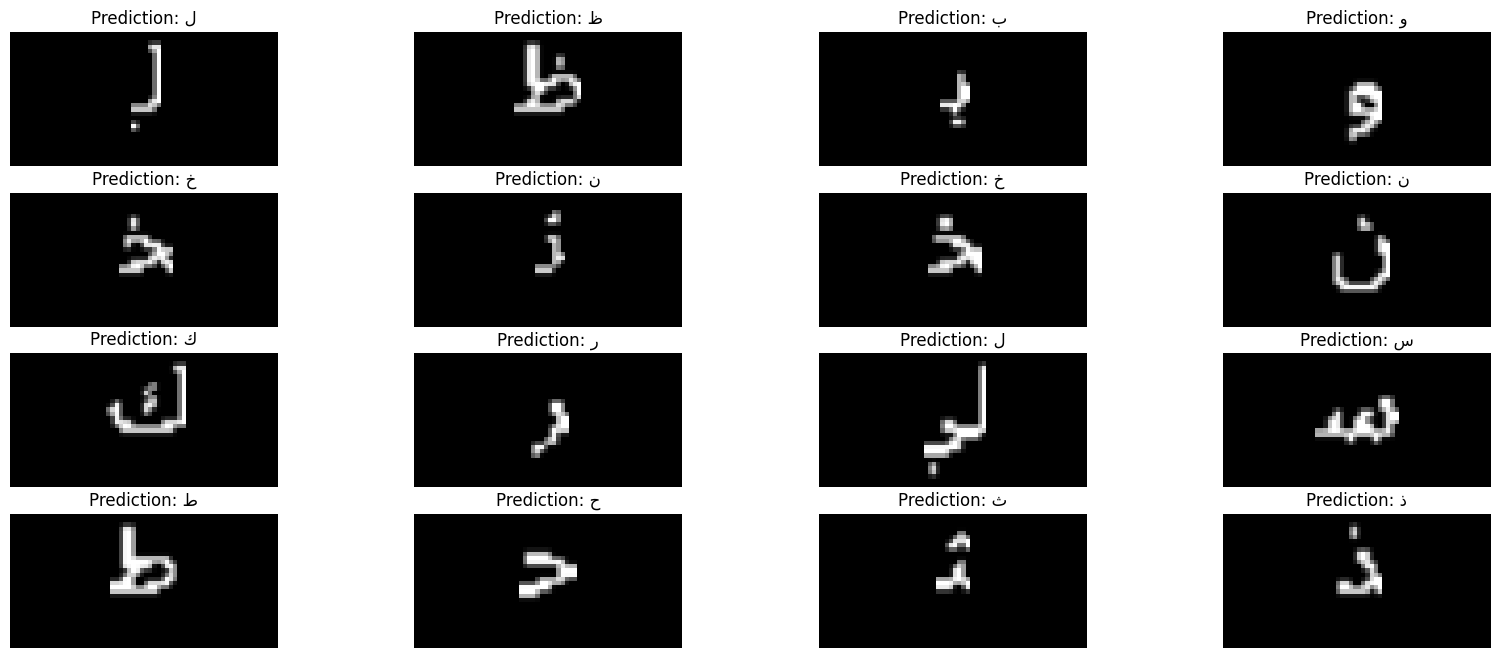

In [ ]:
#@title Checking Results

# Utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

# Checking Results
results = []
for batch in test_ds.take(3):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(20, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        print(pred_texts[i]=='')
        results.append(pred_texts[i])
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

clear_output()
for letter in results:
  print(letter,end=' ')
plt.show()

In [ ]:
#@title The Model's Accuracy
from sklearn.metrics import accuracy_score
# Checking Results
results = []
labels = []

for batch in validation_ds.take(-1):
    batch_images = batch["image"]
    labels_batch = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        results.append(pred_texts[i])
         # Gather indices where label!= padding_token.
        label = labels_batch[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")
        labels.append(label)

accuracy = accuracy_score(labels,results)*100
clear_output()
print("Accuracy: {:.2f}%".format(accuracy))

Accuracy: 95.99%
